<a href="https://colab.research.google.com/github/camillabocciolone/Leonardo-project/blob/main/baselinebandpower.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# import necessari librerie e files

## import libraries

In [1]:
!pip -q install einops tqdm scikit-learn scipy

import os, sys, numpy as np, torch
from pathlib import Path
from scipy.signal import resample_poly
from tqdm.auto import tqdm
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import os, json
import numpy as np
import pandas as pd

from scipy.signal import butter, filtfilt, iirnotch, resample_poly, detrend
from sklearn.model_selection import GroupKFold, GroupShuffleSplit
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader



## --- Repo EEGPT ---

In [2]:
# (opzionale) aggiorna pip/setuptools/wheel per massimizzare compatibilità
!pip install -U pip setuptools wheel

# install minimo per il tuo script
!pip install numpy scipy scikit-learn einops tqdm

# torch: in Colab di solito è già installato; se no:
!pip install torch --index-url https://download.pytorch.org/whl/cpu



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 28.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 37.6 MB/s eta 0:00:00
  Attempting uninstall: setuptools
    Found existing installation: setuptools 75.2.0
    Uninstalling setuptools-75.2.0:
      Successfully uninstalled setuptools-75.2.0
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.34.0 requires jedi>=0.16, which is not installed.


Looking in indexes: https://download.pytorch.org/whl/cpu


## montare il drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Usa il checkpoint direttamente da Drive

In [4]:
from pathlib import Path

ckpt_path = Path(
    "/content/drive/MyDrive/EEGPT/checkpoint/eegpt_mcae_58chs_4s_large4E.ckpt"
)

print("Checkpoint exists:", ckpt_path.exists())


Checkpoint exists: True


## Clona il repo

In [5]:
from pathlib import Path
import os

%cd /content
if not Path("/content/EEGPT").exists():
    !git clone -q https://github.com/BINE022/EEGPT.git

print("Repo OK:", Path("/content/EEGPT").exists())
print("Has downstream:", Path("/content/EEGPT/downstream").exists())


/content
Repo OK: True
Has downstream: True


## Import del modello

In [6]:
import importlib.util
from pathlib import Path

path = Path("/content/EEGPT/downstream/Modules/models/EEGPT_mcae_finetune.py")
print("Model file exists:", path.exists(), path)

spec = importlib.util.spec_from_file_location("eegpt_mcae_finetune", str(path))
mod = importlib.util.module_from_spec(spec)
spec.loader.exec_module(mod)

EEGPTClassifier = mod.EEGPTClassifier
CHANNEL_DICT = mod.CHANNEL_DICT

print("Import OK. CHANNEL_DICT size:", len(CHANNEL_DICT))


Model file exists: True /content/EEGPT/downstream/Modules/models/EEGPT_mcae_finetune.py
Import OK. CHANNEL_DICT size: 62


/content/EEGPT/downstream/Modules/models/EEGPT_mcae_finetune.py:679: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @autocast(True)
/content/EEGPT/downstream/Modules/models/EEGPT_mcae_finetune.py:693: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @autocast(True)


# EEGPT on the true dataset

## ridefiniamo build all usando rec_id

**Scopo**: oltre a subject, crea anche un ID del recording in modo che si possa fare split “a livello di registrazione” (recording-level) e poi prendere tutte le finestre di quella registrazione insieme

In [7]:
data_dir = "/content/drive/My Drive/LL2/LL2/raw_data"

levels = ["highlevel", "midlevel", "lowlevel", "natural"]   # y=0,1,2
tasks  = ["Stroop"]
subjects = range(1, 16)

C = 8
fs_in = 250
FS_OUT = 256
EPOCH_SEC, STRIDE_SEC = 4.0, 2.0
BP_LO, BP_HI = 0.5, 45.0
NOTCH_F0, NOTCH_Q = 50.0, 30.0

# canali OpenBCI (devono essere in CHANNEL_DICT)
my_channels = ["Fp1","Fp2","F7","F3","FZ","F4","F8","C2"]
use_channels_names = [c.upper().strip('.') for c in my_channels]
for c in use_channels_names:
    assert c in CHANNEL_DICT, f"Canale non riconosciuto in CHANNEL_DICT: {c}"
print("Use channels:", use_channels_names)


Use channels: ['FP1', 'FP2', 'F7', 'F3', 'FZ', 'F4', 'F8', 'C2']


## definiamo funzioni per la lettura e preprocessing dei dati

In [8]:
def find_file(level, task, subject):
    # layout A: {level}_Data/{task}-{subject}.txt
    p1 = os.path.join(data_dir, f"{level}_Data", f"{task}-{subject}.txt")
    # layout B: {task}_Data/{level}-{subject}.txt
    p2 = os.path.join(data_dir, f"{task}_Data",  f"{level}-{subject}.txt")
    if os.path.exists(p1): return p1
    if os.path.exists(p2): return p2
    return None

def load_ct_matrix(path, C=8):
    df = pd.read_csv(path, sep=",", header=None, engine="python")
    # prende le prime C colonne come EEG
    X = df.iloc[:, :C].to_numpy(dtype=np.float32).T  # (C,T)
    return X

def bandpass(x, fs, lo=BP_LO, hi=BP_HI, order=4):
    nyq = 0.5 * fs
    b, a = butter(order, [lo/nyq, hi/nyq], btype="band")
    return filtfilt(b, a, x, axis=0)

def notch50(x, fs, f0=NOTCH_F0, Q=NOTCH_Q):
    b, a = iirnotch(w0=f0/(fs/2), Q=Q)
    return filtfilt(b, a, x, axis=0)

def resample_to(x, fs_in, fs_out):
    if fs_in == fs_out:
        return x
    # per 250->256 puoi usare direttamente 128/125
    if int(fs_in)==250 and int(fs_out)==256:
        return resample_poly(x, 128, 125, axis=0)
    # fallback generico
    from math import gcd
    g = gcd(int(fs_in), int(fs_out))
    up, down = fs_out//g, fs_in//g
    return resample_poly(x, up, down, axis=0)

def robust_clip(x, q=0.999):
    hi = np.quantile(x, q, axis=0, keepdims=True)
    lo = np.quantile(x, 1-q, axis=0, keepdims=True)
    return np.clip(x, lo, hi)

def epoch_signal(x_tc, fs, epoch_sec=EPOCH_SEC, stride_sec=STRIDE_SEC):
    # x_tc: (T,C)
    win = int(epoch_sec * fs)
    step = int(stride_sec * fs)
    T = x_tc.shape[0]
    starts = np.arange(0, T - win + 1, step)
    if len(starts)==0:
        return np.empty((0, win, x_tc.shape[1]), dtype=np.float32)
    epochs = np.stack([x_tc[s:s+win] for s in starts], axis=0)  # (N, win, C)
    return epochs

def preprocess_recording(X_ct):
    # X_ct: (C,T) -> epochs: (N,C,1024)
    x = X_ct.T  # (T,C)
    x = bandpass(x, fs_in)
    x = notch50(x, fs_in)
    x = detrend(x, axis=0, type='linear')
    x = robust_clip(x, q=0.999)
    x = resample_to(x, fs_in, FS_OUT)  # (T2,C)
    epochs = epoch_signal(x, FS_OUT)   # (N,1024,C)
    if epochs.shape[0]==0:
        return np.empty((0, C, int(EPOCH_SEC*FS_OUT)), dtype=np.float32)
    epochs = np.transpose(epochs, (0,2,1))  # (N,C,1024)

    # robust z-score per epoca/canale
    med = np.median(epochs, axis=-1, keepdims=True)
    mad = np.median(np.abs(epochs - med), axis=-1, keepdims=True) + 1e-8
    #epochs = (epochs - med) / (1.4826 * mad)
    return epochs.astype(np.float32)


In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch

def debug_preprocessing_plot(X_ct, fs_in=250, fs_out=256, ch_names=None, ch_idx=0, seconds=10):
    x_raw = X_ct.T  # (T,C)
    n = min(x_raw.shape[0], int(seconds*fs_in))

    x_bp = bandpass(x_raw.copy(), fs_in)
    x_notch = notch50(x_bp, fs_in)
    x_det = detrend(x_notch, axis=0, type='linear')
    x_clip = robust_clip(x_det, q=0.999)
    x_rs = resample_to(x_clip, fs_in, fs_out)

    name = ch_names[ch_idx] if ch_names is not None else f"ch{ch_idx}"

    # TIME SERIES
    t = np.arange(n)/fs_in
    plt.figure(figsize=(12,4))
    plt.plot(t, x_raw[:n, ch_idx], label="raw", alpha=0.9)
    plt.plot(t, x_bp[:n, ch_idx], label="bandpass", alpha=0.9)
    plt.plot(t, x_notch[:n, ch_idx], label="bandpass+notch", alpha=0.9)
    plt.title(f"Time series ({name}) first {seconds}s")
    plt.xlabel("s")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # PSD raw vs filtered
    f1, p1 = welch(x_raw[:, ch_idx], fs=fs_in, nperseg=min(len(x_raw), 2*fs_in))
    f2, p2 = welch(x_notch[:, ch_idx], fs=fs_in, nperseg=min(len(x_notch), 2*fs_in))

    plt.figure(figsize=(12,4))
    plt.semilogy(f1, p1, label="raw PSD")
    plt.semilogy(f2, p2, label="filtered PSD")
    plt.axvline(50, linestyle="--")
    plt.xlim(0, 60)
    plt.title(f"PSD ({name}) — 50Hz peak should drop after notch")
    plt.xlabel("Hz")
    plt.legend()
    plt.tight_layout()
    plt.show()

    print("Lengths:")
    print("raw T:", x_raw.shape[0], "fs_in:", fs_in)
    print("resampled T:", x_rs.shape[0], "fs_out:", fs_out)


In [10]:
from pathlib import Path

print("Drive root exists:", Path("/content/drive").exists())
print("MyDrive exists:", Path("/content/drive/MyDrive").exists())
print("My Drive exists:", Path("/content/drive/My Drive").exists())

if Path("/content/drive/MyDrive").exists():
    print("Top folders in MyDrive:", [p.name for p in Path("/content/drive/MyDrive").iterdir() if p.is_dir()][:30])

print("Exists /content/drive:", Path("/content/drive").exists())
print("List /content:", os.listdir("/content")[:30])

if Path("/content/drive").exists():
    print("List /content/drive:", os.listdir("/content/drive")[:50])


Drive root exists: True
MyDrive exists: True
My Drive exists: True
Top folders in MyDrive: ['Progetto AN2DL', 'Colab Notebooks', 'CSI (1)', 'Copia di CSI', 'CSI', 'EEGPT', 'LL2']
Exists /content/drive: True
List /content: ['.config', 'drive', 'EEGPT', 'sample_data']
List /content/drive: ['MyDrive', '.shortcut-targets-by-id', '.Trash-0', '.Encrypted']


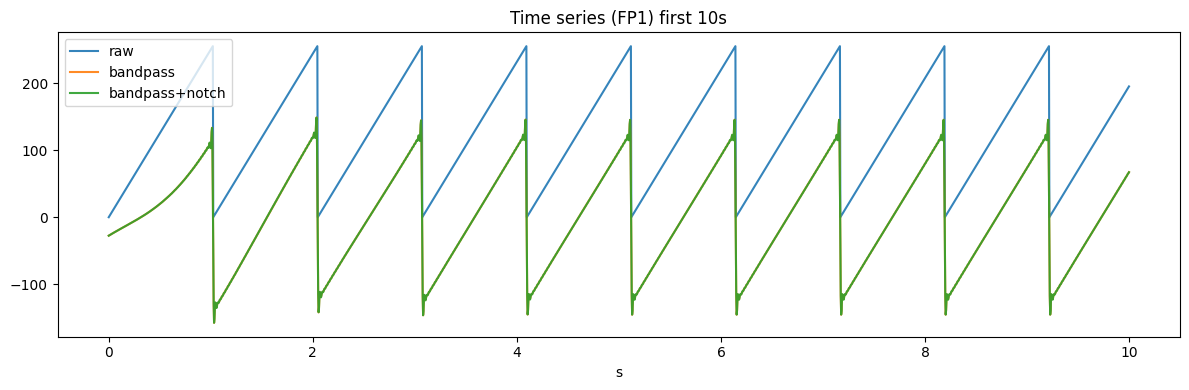

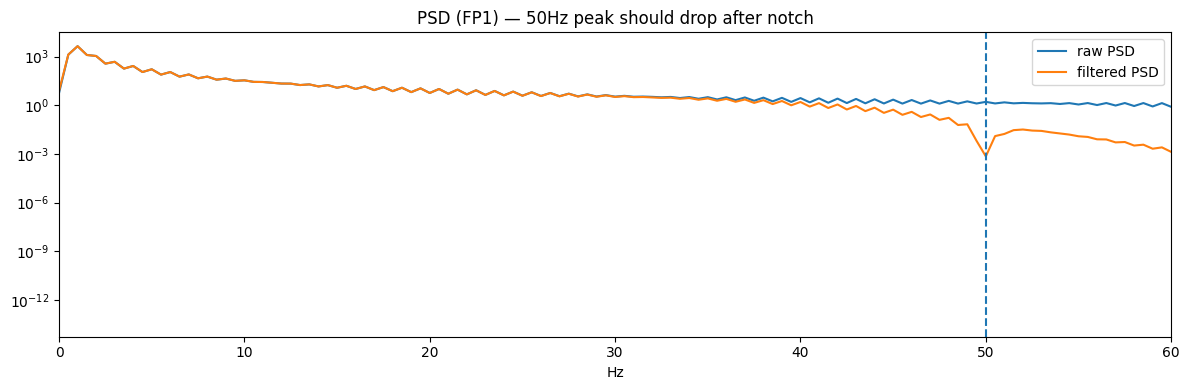

Lengths:
raw T: 28168 fs_in: 250
resampled T: 28845 fs_out: 256


In [11]:
path = find_file("highlevel", "Stroop", 1)
X_ct = load_ct_matrix(path, C=8)
debug_preprocessing_plot(X_ct, fs_in=250, fs_out=256, ch_names=use_channels_names, ch_idx=0, seconds=10)


## build_all

In [12]:
def build_all(levels, tasks, subjects, C=8):
    X_list, y_list, subj_list, rec_list = [], [], [], []
    for li, level in enumerate(levels):
        for task in tasks:
            for s in subjects:
                path = find_file(level, task, s)
                if path is None:
                    print(f"[SKIP] missing file: {level}/{task}/S{s}")
                    continue
                try:
                    X_ct = load_ct_matrix(path, C=C)
                    epochs = preprocess_recording(X_ct)  # (Nw,C,1024)
                    if epochs.shape[0]==0:
                        print(f"[SKIP] no epochs: {os.path.basename(path)}")
                        continue

                    rec_id = f"{task}|{level}|S{s}"
                    X_list.append(epochs)
                    y_list.extend([li]*len(epochs))
                    subj_list.extend([f"S{s}"]*len(epochs))
                    rec_list.extend([rec_id]*len(epochs))
                except Exception as e:
                    print(f"[ERROR] {os.path.basename(path)}: {e}")
                    continue

    X_all = np.concatenate(X_list, axis=0) if X_list else np.empty((0,C,int(EPOCH_SEC*FS_OUT)), dtype=np.float32)
    y_all = np.array(y_list, dtype=np.int64)
    meta = {
        "subject": np.array(subj_list),
        "rec_id":  np.array(rec_list),
    }
    return X_all, y_all, meta

X_all, y_all, meta = build_all(levels, tasks, subjects, C=8)
print("X_all:", X_all.shape, "y_all:", y_all.shape, "unique rec:", len(np.unique(meta["rec_id"])))


X_all: (2521, 8, 1024) y_all: (2521,) unique rec: 60


## baseline bandpower

In [13]:
import numpy as np
from scipy.signal import welch

BANDS = {
    "delta": (1.0, 4.0),
    "theta": (4.0, 8.0),
    "alpha": (8.0, 13.0),
    "beta":  (13.0, 30.0),
    "gamma": (30.0, 45.0),
}

def bandpower_features(X_w, fs=256, bands=BANDS, relative=False, logpow=True):
    """
    X_w: (Nwin, C, T)
    return: (Nwin, C*nbands)
    """
    N, C, T = X_w.shape
    nb = len(bands)
    feats = np.zeros((N, C, nb), dtype=np.float32)

    nperseg = min(T, int(2*fs))  # 2 sec
    for i in range(N):
        for ch in range(C):
            f, Pxx = welch(X_w[i, ch], fs=fs, nperseg=nperseg, noverlap=nperseg//2)

            m_tot = (f >= 1.0) & (f <= 45.0)
            total = np.trapz(Pxx[m_tot], f[m_tot]) + 1e-12

            for b_i, (name, (lo, hi)) in enumerate(bands.items()):
                m = (f >= lo) & (f <= hi)
                bp = np.trapz(Pxx[m], f[m]) + 1e-12
                if relative:
                    bp = bp / total
                if logpow:
                    bp = np.log(bp)
                feats[i, ch, b_i] = bp

    return feats.reshape(N, C*nb)


In [14]:
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, confusion_matrix, classification_report
import pandas as pd

def loso_bandpower_eval_from_buildall(X_all, y_all, meta, fs=256, relative=False):
    """
    LOSO: leave-one-subject-out sulle finestre.
    groups = meta['subject'] (S1..S15)
    """
    groups = np.asarray(meta["subject"]).astype(str)

    F = bandpower_features(X_all, fs=fs, relative=relative, logpow=True)

    logo = LeaveOneGroupOut()
    y_true_all, y_pred_all = [], []
    rows = []

    n_classes = int(np.max(y_all) + 1)

    for fold, (tr, te) in enumerate(logo.split(F, y_all, groups=groups), 1):
        test_subject = groups[te][0]

        scaler = StandardScaler()
        Xtr = scaler.fit_transform(F[tr])
        Xte = scaler.transform(F[te])

        clf = LogisticRegression(
            max_iter=5000,
            solver="lbfgs",
            multi_class="multinomial"
        )
        clf.fit(Xtr, y_all[tr])
        pred = clf.predict(Xte)

        acc  = accuracy_score(y_all[te], pred)
        bacc = balanced_accuracy_score(y_all[te], pred)
        f1m  = f1_score(y_all[te], pred, average="macro")
        f1w  = f1_score(y_all[te], pred, average="weighted")

        rows.append({
            "subject": test_subject,
            "n_test_windows": len(te),
            "acc": acc,
            "balanced_acc": bacc,
            "f1_macro": f1m,
            "f1_weighted": f1w
        })

        y_true_all.append(y_all[te])
        y_pred_all.append(pred)

        print(f"fold {fold:02d} | test_subject={test_subject} | n_win={len(te)} | acc={acc:.3f} | f1m={f1m:.3f}")

    y_true_all = np.concatenate(y_true_all)
    y_pred_all = np.concatenate(y_pred_all)

    cm = confusion_matrix(y_true_all, y_pred_all, labels=list(range(n_classes)))

    print("\n=== GLOBAL ===")
    print("acc:", accuracy_score(y_true_all, y_pred_all))
    print("balanced_acc:", balanced_accuracy_score(y_true_all, y_pred_all))
    print("f1_macro:", f1_score(y_true_all, y_pred_all, average="macro"))
    print("f1_weighted:", f1_score(y_true_all, y_pred_all, average="weighted"))
    print("Confusion matrix:\n", cm)
    print("\nReport:\n", classification_report(y_true_all, y_pred_all, digits=3))

    df = pd.DataFrame(rows).sort_values("subject").reset_index(drop=True)
    return df, cm


In [15]:
print("=== Baseline 1: LOG bandpower (absolute) ===")
df_abs, cm_abs = loso_bandpower_eval_from_buildall(X_all, y_all, meta, fs=256, relative=False)
display(df_abs)

print("\n=== Baseline 2: LOG bandpower (relative) ===")
df_rel, cm_rel = loso_bandpower_eval_from_buildall(X_all, y_all, meta, fs=256, relative=True)
display(df_rel)


=== Baseline 1: LOG bandpower (absolute) ===


/tmp/ipython-input-1501374552.py:27: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  total = np.trapz(Pxx[m_tot], f[m_tot]) + 1e-12
/tmp/ipython-input-1501374552.py:31: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  bp = np.trapz(Pxx[m], f[m]) + 1e-12
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


fold 01 | test_subject=S1 | n_win=174 | acc=0.259 | f1m=0.218


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


fold 02 | test_subject=S10 | n_win=158 | acc=0.544 | f1m=0.416


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


fold 03 | test_subject=S11 | n_win=179 | acc=0.430 | f1m=0.400


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


fold 04 | test_subject=S12 | n_win=166 | acc=0.422 | f1m=0.377
fold 05 | test_subject=S13 | n_win=154 | acc=0.409 | f1m=0.320


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


fold 06 | test_subject=S14 | n_win=137 | acc=0.540 | f1m=0.399
fold 07 | test_subject=S15 | n_win=156 | acc=0.538 | f1m=0.445


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


fold 08 | test_subject=S2 | n_win=225 | acc=0.476 | f1m=0.197
fold 09 | test_subject=S3 | n_win=153 | acc=0.471 | f1m=0.367


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


fold 10 | test_subject=S4 | n_win=126 | acc=0.262 | f1m=0.192
fold 11 | test_subject=S5 | n_win=176 | acc=0.438 | f1m=0.313
fold 12 | test_subject=S6 | n_win=145 | acc=0.255 | f1m=0.171


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


fold 13 | test_subject=S7 | n_win=146 | acc=0.479 | f1m=0.410
fold 14 | test_subject=S8 | n_win=197 | acc=0.355 | f1m=0.244
fold 15 | test_subject=S9 | n_win=229 | acc=0.555 | f1m=0.368

=== GLOBAL ===
acc: 0.4331614438714796
balanced_acc: 0.3771279315301469
f1_macro: 0.36609419037626745
f1_weighted: 0.41301208419159724
Confusion matrix:
 [[385  94 115 150]
 [226  46  74 113]
 [169  61 114 138]
 [140  58  91 547]]


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



Report:
               precision    recall  f1-score   support

           0      0.418     0.517     0.463       744
           1      0.178     0.100     0.128       459
           2      0.289     0.237     0.260       482
           3      0.577     0.654     0.613       836

    accuracy                          0.433      2521
   macro avg      0.366     0.377     0.366      2521
weighted avg      0.403     0.433     0.413      2521



,subject,n_test_windows,acc,balanced_acc,f1_macro,f1_weighted
0,S1,174,0.258621,0.243371,0.217887,0.235843
1,S10,158,0.544304,0.444620,0.415525,0.492497
2,S11,179,0.430168,0.390537,0.399653,0.440789
3,S12,166,0.421687,0.429870,0.376530,0.395183
4,S13,154,0.409091,0.351913,0.320080,0.358564
5,S14,137,0.540146,0.438051,0.398833,0.477343
6,S15,156,0.538462,0.489465,0.444970,0.476502
7,S2,225,0.475556,0.254933,0.197384,0.354097
8,S3,153,0.470588,0.414520,0.366557,0.412895
9,S4,126,0.261905,0.296569,0.191978,0.242498



=== Baseline 2: LOG bandpower (relative) ===


/tmp/ipython-input-1501374552.py:27: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  total = np.trapz(Pxx[m_tot], f[m_tot]) + 1e-12
/tmp/ipython-input-1501374552.py:31: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  bp = np.trapz(Pxx[m], f[m]) + 1e-12
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.war

fold 01 | test_subject=S1 | n_win=174 | acc=0.201 | f1m=0.174
fold 02 | test_subject=S10 | n_win=158 | acc=0.487 | f1m=0.326


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


fold 03 | test_subject=S11 | n_win=179 | acc=0.419 | f1m=0.330
fold 04 | test_subject=S12 | n_win=166 | acc=0.398 | f1m=0.371


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


fold 05 | test_subject=S13 | n_win=154 | acc=0.338 | f1m=0.229
fold 06 | test_subject=S14 | n_win=137 | acc=0.533 | f1m=0.363


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


fold 07 | test_subject=S15 | n_win=156 | acc=0.558 | f1m=0.459
fold 08 | test_subject=S2 | n_win=225 | acc=0.467 | f1m=0.203


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


fold 09 | test_subject=S3 | n_win=153 | acc=0.451 | f1m=0.365
fold 10 | test_subject=S4 | n_win=126 | acc=0.413 | f1m=0.359


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


fold 11 | test_subject=S5 | n_win=176 | acc=0.466 | f1m=0.377
fold 12 | test_subject=S6 | n_win=145 | acc=0.248 | f1m=0.223


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


fold 13 | test_subject=S7 | n_win=146 | acc=0.418 | f1m=0.365
fold 14 | test_subject=S8 | n_win=197 | acc=0.381 | f1m=0.259
fold 15 | test_subject=S9 | n_win=229 | acc=0.541 | f1m=0.358

=== GLOBAL ===
acc: 0.4240380801269338
balanced_acc: 0.36210215596563394
f1_macro: 0.34606952430226945
f1_weighted: 0.39655515201616626
Confusion matrix:
 [[397  64 117 166]
 [196  45  97 121]
 [205  55  76 146]
 [173  34  78 551]]

Report:
               precision    recall  f1-score   support

           0      0.409     0.534     0.463       744
           1      0.227     0.098     0.137       459
           2      0.207     0.158     0.179       482
           3      0.560     0.659     0.605       836

    accuracy                          0.424      2521
   macro avg      0.351     0.362     0.346      2521
weighted avg      0.387     0.424     0.397      2521



/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


,subject,n_test_windows,acc,balanced_acc,f1_macro,f1_weighted
0,S1,174,0.201149,0.189908,0.173807,0.186078
1,S10,158,0.487342,0.382688,0.326067,0.410714
2,S11,179,0.418994,0.357357,0.330179,0.396637
3,S12,166,0.397590,0.368639,0.371245,0.407699
4,S13,154,0.337662,0.301667,0.228849,0.248232
5,S14,137,0.532847,0.422930,0.363446,0.447040
6,S15,156,0.557692,0.504749,0.459259,0.492256
7,S2,225,0.466667,0.247887,0.202528,0.362650
8,S3,153,0.450980,0.401040,0.365463,0.408176
9,S4,126,0.412698,0.413695,0.359097,0.389322


# cambiamenti
- 128 patch size vuol dire che dati 4 s si hanno 1024/128 = 8 campioni invece degli attuali 64 patch size che sarebbe 1024/64=16 campioni
- in task dividere aithmetic e stroops
- Il robust z-score per epoca (MAD) può “ammazzare” la separabilità tra classi --> eliminarlo
- aggiungere interpolazione per avere istanti temporali equidistanti
- cambiare parametri tsn
- Patch stride: prova 128 e 256
- Bonus: 2 baseline che ti dicono subito se il dataset ha segnale
A) Bandpower baseline (fortissima per workload)
Estrai per finestra:
log bandpower in delta/theta/alpha/beta (per canale)
poi LDA / logistic
Se questa baseline non supera tipo ~45–55% (3 classi), il dataset potrebbe avere segnale debole o label rumorose.
B) Relative power
Stessa cosa, ma dividi ogni banda per il totale (stabilizza soggetti).
- cambiare dataset


# EEGPT on true datset using interpolation

In [16]:
import pandas as pd, numpy as np

path = find_file("highlevel", "Stroop", 3)  # cambia soggetto/level se vuoi
df = pd.read_csv(path, sep=",", header=None, engine="python")

t = pd.to_numeric(df.iloc[:, 22], errors="coerce").to_numpy()
t = t[~np.isnan(t)]
t = t - t[0]
dt = np.diff(t)

print("dt mean:", dt.mean())
print("dt std :", dt.std())
print("dt min :", dt.min(), "dt max:", dt.max())
print("fs approx:", 1/dt.mean())
print("dropouts (dt > 2*mean):", np.sum(dt > 2*dt.mean()))


dt mean: 0.005021807866576204
dt std : 0.03322592742888936
dt min : 7.3909759521484375e-06 dt max: 0.48257970809936523
fs approx: 199.13147347904922
dropouts (dt > 2*mean): 1410


In [17]:
# ====== SETUP ======
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import os
import numpy as np
import pandas as pd

from scipy.interpolate import interp1d
from scipy.signal import butter, filtfilt, iirnotch, resample_poly, detrend
from sklearn.model_selection import GroupKFold, GroupShuffleSplit

# ====== PARAMETRI (come i tuoi) ======
data_dir = "/content/drive/My Drive/LL2/LL2/raw_data"

levels   = ["highlevel", "midlevel", "lowlevel", "natural"]   # y=0,1,2
tasks    = ["Stroop"]                               # cambia se vuoi anche Arithmetic ecc
subjects = range(1, 16)

C = 8
TIME_COL = 22

# dal tuo log: fs approx ~199 => usiamo griglia uniforme a 200Hz, poi portiamo a 256
FS_U   = 200.0
FS_OUT = 256.0

EPOCH_SEC  = 4.0
STRIDE_SEC = 2.0

BP_LO, BP_HI = 0.5, 45.0
NOTCH_F0, NOTCH_Q = 50.0, 30.0


# ====== UTILS: trova file in entrambi i layout ======
def find_file(level, task, subject):
    p1 = os.path.join(data_dir, f"{level}_Data", f"{task}-{subject}.txt")
    p2 = os.path.join(data_dir, f"{task}_Data",  f"{level}-{subject}.txt")
    if os.path.exists(p1): return p1
    if os.path.exists(p2): return p2
    return None


# ====== LOAD: (C,T) + time ======
def load_ct_with_time(path, C=8, time_col=22):
    df = pd.read_csv(path, sep=",", header=None, engine="python")

    # segnali EEG: prime C colonne
    X = df.iloc[:, :C].to_numpy(dtype=np.float32).T  # (C, T_raw)

    # tempo
    t = pd.to_numeric(df.iloc[:, time_col], errors="coerce").to_numpy()

    # rimuovi NaN tempo
    mask = ~np.isnan(t)
    X = X[:, mask]
    t = t[mask].astype(np.float64)

    # porta a partire da 0
    t = t - t[0]

    # tieni solo t strettamente crescente (rimuove duplicati/inversioni)
    keep = np.r_[True, np.diff(t) > 0]
    X = X[:, keep]
    t = t[keep]

    # ulteriore safety: rimuovi eventuali duplicati rimasti
    t_unique, idx = np.unique(t, return_index=True)
    t = t_unique
    X = X[:, idx]

    return X, t


# ====== Interpolazione su griglia uniforme ======
def to_uniform_grid(X_ct, t, fs_u=200.0):
    t_end = t[-1]
    t_u = np.arange(0.0, t_end, 1.0/fs_u)

    f = interp1d(
    t, X_ct, axis=1, kind="linear",
    bounds_error=False,
    fill_value=(X_ct[:, 0], X_ct[:, -1])  # clamp ai bordi, NO extrapolate
)

    X_u = f(t_u).astype(np.float32)  # (C, T_u)
    return X_u


# ====== Filtri + clip ======
def bandpass_tc(x_tc, fs, lo=0.5, hi=45.0, order=4):
    nyq = 0.5 * fs
    b, a = butter(order, [lo/nyq, hi/nyq], btype="band")
    return filtfilt(b, a, x_tc, axis=0)

def notch_tc(x_tc, fs, f0=50.0, Q=30.0):
    b, a = iirnotch(w0=f0/(fs/2), Q=Q)
    return filtfilt(b, a, x_tc, axis=0)

def robust_clip_tc(x_tc, q=0.999):
    hi = np.quantile(x_tc, q, axis=0, keepdims=True)
    lo = np.quantile(x_tc, 1-q, axis=0, keepdims=True)
    return np.clip(x_tc, lo, hi)


# ====== Epoching (x_tc: (T,C) -> (N,C,1024)) ======
def epoch_signal_tc(x_tc, fs, epoch_sec=4.0, stride_sec=2.0):
    win = int(epoch_sec * fs)
    step = int(stride_sec * fs)
    T = x_tc.shape[0]
    starts = np.arange(0, T - win + 1, step)
    if len(starts) == 0:
        return np.empty((0, x_tc.shape[1], win), dtype=np.float32)
    # (N,win,C) -> (N,C,win)
    epochs = np.stack([x_tc[s:s+win] for s in starts], axis=0).astype(np.float32)
    return np.transpose(epochs, (0, 2, 1))


# ====== Preprocess completo di una registrazione irregolare ======
def preprocess_recording_irregular(path, C=8):
    # 1) load (C,T) e time
    X_ct, t = load_ct_with_time(path, C=C, time_col=TIME_COL)

    # 2) interpolazione a griglia uniforme FS_U
    X_u = to_uniform_grid(X_ct, t, fs_u=FS_U)   # (C,Tu)

    # 3) filtri su FS_U
    x = X_u.T  # (Tu,C)
    x = bandpass_tc(x, FS_U, lo=BP_LO, hi=BP_HI)
    x = notch_tc(x, FS_U, f0=NOTCH_F0, Q=NOTCH_Q)
    x = detrend(x, axis=0, type="linear")
    x = robust_clip_tc(x, q=0.999)

    # 4) resample FS_U -> 256
    # 200 -> 256 = 32/25
    x = resample_poly(x, up=32, down=25, axis=0).astype(np.float32)  # (T256,C)

    # 5) epoching (N,C,1024) con fs=256
    epochs = epoch_signal_tc(x, FS_OUT, epoch_sec=EPOCH_SEC, stride_sec=STRIDE_SEC)
    if epochs.shape[0] == 0:
        return np.empty((0, C, int(EPOCH_SEC*FS_OUT)), dtype=np.float32)

    # 6) robust z-score per epoca/canale
    med = np.median(epochs, axis=-1, keepdims=True)
    mad = np.median(np.abs(epochs - med), axis=-1, keepdims=True) + 1e-8
    #epochs = (epochs - med) / (1.4826 * mad)

    return epochs.astype(np.float32)  # (N,C,1024)


# ====== BUILD ALL: X_all, y_all, meta ======
def build_all(levels, tasks, subjects, C=8, verbose=True):
    X_list = []
    y_list = []
    subj_list = []
    task_list = []
    level_list = []
    recid_list = []   # id per TSN: 1 registrazione = 1 rec_id

    rec_id = 0
    for li, level in enumerate(levels):
        for task in tasks:
            for s in subjects:
                path = find_file(level, task, s)
                if path is None:
                    if verbose: print(f"[SKIP] missing file: level={level} task={task} subj={s}")
                    continue
                try:
                    epochs = preprocess_recording_irregular(path, C=C)  # (N,C,1024)
                    if epochs.shape[0] == 0:
                        if verbose: print(f"[SKIP] no epochs: {os.path.basename(path)}")
                        continue

                    X_list.append(epochs)
                    y_list.extend([li] * len(epochs))
                    subj_list.extend([f"S{s}"] * len(epochs))
                    task_list.extend([task] * len(epochs))
                    level_list.extend([level] * len(epochs))
                    recid_list.extend([rec_id] * len(epochs))

                    rec_id += 1
                except Exception as e:
                    if verbose: print(f"[ERR] {os.path.basename(path)}: {e}")
                    continue

    if len(X_list) == 0:
        return (np.empty((0, C, int(EPOCH_SEC*FS_OUT)), dtype=np.float32),
                np.empty((0,), dtype=np.int64),
                {"subject": np.array([]), "task": np.array([]), "level": np.array([]), "rec_id": np.array([])})

    X_all = np.concatenate(X_list, axis=0).astype(np.float32)  # (N,C,1024)
    y_all = np.array(y_list, dtype=np.int64)

    meta = {
        "subject": np.array(subj_list),
        "task":    np.array(task_list),
        "level":   np.array(level_list),
        "rec_id":  np.array(recid_list, dtype=np.int64),
    }
    return X_all, y_all, meta

# ====== ESECUZIONE ======
X_win, y_win, meta = build_all(levels, tasks, subjects, C=C, verbose=True)
print("X_all:", X_win.shape, "y_all:", y_win.shape)
print("unique y:", np.unique(y_win, return_counts=True))


# 2) recording-level table
rec_id_win = meta["rec_id"]
subj_win   = meta["subject"]
y_win_lbl  = y_win

rec_ids = np.unique(rec_id_win)

rec_subjects = []
rec_y = []
for rid in rec_ids:
    idx0 = np.where(rec_id_win == rid)[0][0]
    rec_subjects.append(subj_win[idx0])
    rec_y.append(int(y_win_lbl[idx0]))

rec_subjects = np.array(rec_subjects)
rec_y = np.array(rec_y, dtype=np.int64)

# 3) split subject-independent sui RECORDING
gkf = GroupKFold(n_splits=5)
folds = []
for trainval_idx, test_idx in gkf.split(rec_ids, rec_y, groups=rec_subjects):
    gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    tr_rel, va_rel = next(gss.split(trainval_idx, groups=rec_subjects[trainval_idx]))
    tr_idx = trainval_idx[tr_rel]
    va_idx = trainval_idx[va_rel]
    folds.append({
        "train_rec": set(rec_ids[tr_idx]),
        "val_rec":   set(rec_ids[va_idx]),
        "test_rec":  set(rec_ids[test_idx])
    })

FOLD = 0
train_rec = folds[FOLD]["train_rec"]
val_rec   = folds[FOLD]["val_rec"]
test_rec  = folds[FOLD]["test_rec"]

print("Fold0 recordings:", len(train_rec), len(val_rec), len(test_rec))



# ====== recording-level table ======
rec_id_win = meta["rec_id"]
subj_win   = meta["subject"]
y_win_lbl  = y_win  # (n_windows,)

rec_ids = np.unique(rec_id_win)

rec_subjects = []
rec_y = []
for rid in rec_ids:
    idx0 = np.where(rec_id_win == rid)[0][0]
    rec_subjects.append(subj_win[idx0])
    rec_y.append(int(y_win_lbl[idx0]))

rec_subjects = np.array(rec_subjects)
rec_y = np.array(rec_y, dtype=np.int64)

# ====== 5-fold subject-independent sui RECORDING ======
gkf = GroupKFold(n_splits=5)
folds = []
for trainval_idx, test_idx in gkf.split(rec_ids, rec_y, groups=rec_subjects):
    gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    tr_rel, va_rel = next(gss.split(trainval_idx, groups=rec_subjects[trainval_idx]))
    tr_idx = trainval_idx[tr_rel]
    va_idx = trainval_idx[va_rel]
    folds.append({
        "train_rec": set(rec_ids[tr_idx]),
        "val_rec":   set(rec_ids[va_idx]),
        "test_rec":  set(rec_ids[test_idx])
    })

FOLD = 0
train_rec = folds[FOLD]["train_rec"]
val_rec   = folds[FOLD]["val_rec"]
test_rec  = folds[FOLD]["test_rec"]

print("Fold0 recordings:", len(train_rec), len(val_rec), len(test_rec))







Mounted at /content/drive
X_all: (2590, 8, 1024) y_all: (2590,)
unique y: (array([0, 1, 2, 3]), array([764, 473, 488, 865]))
Fold0 recordings: 36 12 12
Fold0 recordings: 36 12 12


## baseline bandpower

In [18]:
import numpy as np
from scipy.signal import welch

BANDS = {
    "delta": (1.0, 4.0),
    "theta": (4.0, 8.0),
    "alpha": (8.0, 13.0),
    "beta":  (13.0, 30.0),
    "gamma": (30.0, 45.0),
}

def bandpower_features(X_w, fs=256, bands=BANDS, relative=False, logpow=True):
    """
    X_w: (Nwin, C, T)
    return: (Nwin, C*nbands)
    """
    N, C, T = X_w.shape
    nb = len(bands)
    feats = np.zeros((N, C, nb), dtype=np.float32)

    nperseg = min(T, int(2*fs))  # 2 sec
    for i in range(N):
        for ch in range(C):
            f, Pxx = welch(X_w[i, ch], fs=fs, nperseg=nperseg, noverlap=nperseg//2)

            m_tot = (f >= 1.0) & (f <= 45.0)
            total = np.trapz(Pxx[m_tot], f[m_tot]) + 1e-12

            for b_i, (name, (lo, hi)) in enumerate(bands.items()):
                m = (f >= lo) & (f <= hi)
                bp = np.trapz(Pxx[m], f[m]) + 1e-12
                if relative:
                    bp = bp / total
                if logpow:
                    bp = np.log(bp)
                feats[i, ch, b_i] = bp

    return feats.reshape(N, C*nb)


In [19]:
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, confusion_matrix, classification_report
import pandas as pd

def loso_bandpower_eval_from_buildall(X_all, y_all, meta, fs=256, relative=False):
    """
    LOSO: leave-one-subject-out sulle finestre.
    groups = meta['subject'] (S1..S15)
    """
    groups = np.asarray(meta["subject"]).astype(str)

    F = bandpower_features(X_all, fs=fs, relative=relative, logpow=True)

    logo = LeaveOneGroupOut()
    y_true_all, y_pred_all = [], []
    rows = []

    n_classes = int(np.max(y_all) + 1)

    for fold, (tr, te) in enumerate(logo.split(F, y_all, groups=groups), 1):
        test_subject = groups[te][0]

        scaler = StandardScaler()
        Xtr = scaler.fit_transform(F[tr])
        Xte = scaler.transform(F[te])

        clf = LogisticRegression(
            max_iter=5000,
            solver="lbfgs",
            multi_class="multinomial"
        )
        clf.fit(Xtr, y_all[tr])
        pred = clf.predict(Xte)

        acc  = accuracy_score(y_all[te], pred)
        bacc = balanced_accuracy_score(y_all[te], pred)
        f1m  = f1_score(y_all[te], pred, average="macro")
        f1w  = f1_score(y_all[te], pred, average="weighted")

        rows.append({
            "subject": test_subject,
            "n_test_windows": len(te),
            "acc": acc,
            "balanced_acc": bacc,
            "f1_macro": f1m,
            "f1_weighted": f1w
        })

        y_true_all.append(y_all[te])
        y_pred_all.append(pred)

        print(f"fold {fold:02d} | test_subject={test_subject} | n_win={len(te)} | acc={acc:.3f} | f1m={f1m:.3f}")

    y_true_all = np.concatenate(y_true_all)
    y_pred_all = np.concatenate(y_pred_all)

    cm = confusion_matrix(y_true_all, y_pred_all, labels=list(range(n_classes)))

    print("\n=== GLOBAL ===")
    print("acc:", accuracy_score(y_true_all, y_pred_all))
    print("balanced_acc:", balanced_accuracy_score(y_true_all, y_pred_all))
    print("f1_macro:", f1_score(y_true_all, y_pred_all, average="macro"))
    print("f1_weighted:", f1_score(y_true_all, y_pred_all, average="weighted"))
    print("Confusion matrix:\n", cm)
    print("\nReport:\n", classification_report(y_true_all, y_pred_all, digits=3))

    df = pd.DataFrame(rows).sort_values("subject").reset_index(drop=True)
    return df, cm


In [20]:
print("=== Baseline 1: LOG bandpower (absolute) ===")
df_abs, cm_abs = loso_bandpower_eval_from_buildall(X_win, y_win, meta, fs=256, relative=False)
display(df_abs)

print("\n=== Baseline 2: LOG bandpower (relative) ===")
df_rel, cm_rel = loso_bandpower_eval_from_buildall(X_win, y_win, meta, fs=256, relative=True)
display(df_rel)


=== Baseline 1: LOG bandpower (absolute) ===


/tmp/ipython-input-1501374552.py:27: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  total = np.trapz(Pxx[m_tot], f[m_tot]) + 1e-12
/tmp/ipython-input-1501374552.py:31: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  bp = np.trapz(Pxx[m], f[m]) + 1e-12
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.war

fold 01 | test_subject=S1 | n_win=190 | acc=0.368 | f1m=0.299
fold 02 | test_subject=S10 | n_win=159 | acc=0.321 | f1m=0.190


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


fold 03 | test_subject=S11 | n_win=183 | acc=0.306 | f1m=0.225
fold 04 | test_subject=S12 | n_win=167 | acc=0.281 | f1m=0.265


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


fold 05 | test_subject=S13 | n_win=154 | acc=0.461 | f1m=0.297
fold 06 | test_subject=S14 | n_win=139 | acc=0.446 | f1m=0.272


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


fold 07 | test_subject=S15 | n_win=157 | acc=0.459 | f1m=0.390
fold 08 | test_subject=S2 | n_win=225 | acc=0.542 | f1m=0.341


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


fold 09 | test_subject=S3 | n_win=179 | acc=0.413 | f1m=0.305


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


fold 10 | test_subject=S4 | n_win=132 | acc=0.379 | f1m=0.144
fold 11 | test_subject=S5 | n_win=175 | acc=0.280 | f1m=0.219


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


fold 12 | test_subject=S6 | n_win=152 | acc=0.270 | f1m=0.163
fold 13 | test_subject=S7 | n_win=150 | acc=0.207 | f1m=0.087


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


fold 14 | test_subject=S8 | n_win=196 | acc=0.265 | f1m=0.190


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


fold 15 | test_subject=S9 | n_win=232 | acc=0.164 | f1m=0.146

=== GLOBAL ===
acc: 0.3420849420849421
balanced_acc: 0.28778977986371723
f1_macro: 0.2692552017854193
f1_weighted: 0.30701602937936845
Confusion matrix:
 [[327  40  24 373]
 [147  29  64 233]
 [159  39  55 235]
 [294  53  43 475]]

Report:
               precision    recall  f1-score   support

           0      0.353     0.428     0.387       764
           1      0.180     0.061     0.091       473
           2      0.296     0.113     0.163       488
           3      0.361     0.549     0.436       865

    accuracy                          0.342      2590
   macro avg      0.297     0.288     0.269      2590
weighted avg      0.313     0.342     0.307      2590



,subject,n_test_windows,acc,balanced_acc,f1_macro,f1_weighted
0,S1,190,0.368421,0.335686,0.298889,0.322081
1,S10,159,0.320755,0.250186,0.189634,0.246001
2,S11,183,0.306011,0.248309,0.225051,0.254251
3,S12,167,0.281437,0.267629,0.265295,0.276047
4,S13,154,0.461039,0.372159,0.296780,0.364600
5,S14,139,0.446043,0.357032,0.272084,0.343433
6,S15,157,0.458599,0.474992,0.389556,0.399606
7,S2,225,0.542222,0.343123,0.340834,0.486391
8,S3,179,0.413408,0.351676,0.304842,0.350158
9,S4,132,0.378788,0.245098,0.143678,0.222048



=== Baseline 2: LOG bandpower (relative) ===


/tmp/ipython-input-1501374552.py:27: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  total = np.trapz(Pxx[m_tot], f[m_tot]) + 1e-12
/tmp/ipython-input-1501374552.py:31: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  bp = np.trapz(Pxx[m], f[m]) + 1e-12
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


fold 01 | test_subject=S1 | n_win=190 | acc=0.411 | f1m=0.310


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


fold 02 | test_subject=S10 | n_win=159 | acc=0.333 | f1m=0.219


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


fold 03 | test_subject=S11 | n_win=183 | acc=0.350 | f1m=0.246


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


fold 04 | test_subject=S12 | n_win=167 | acc=0.228 | f1m=0.164
fold 05 | test_subject=S13 | n_win=154 | acc=0.383 | f1m=0.232


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


fold 06 | test_subject=S14 | n_win=139 | acc=0.381 | f1m=0.248


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


fold 07 | test_subject=S15 | n_win=157 | acc=0.312 | f1m=0.225


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


fold 08 | test_subject=S2 | n_win=225 | acc=0.480 | f1m=0.285
fold 09 | test_subject=S3 | n_win=179 | acc=0.464 | f1m=0.349


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


fold 10 | test_subject=S4 | n_win=132 | acc=0.280 | f1m=0.216
fold 11 | test_subject=S5 | n_win=175 | acc=0.337 | f1m=0.251


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


fold 12 | test_subject=S6 | n_win=152 | acc=0.342 | f1m=0.236
fold 13 | test_subject=S7 | n_win=150 | acc=0.213 | f1m=0.147


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


fold 14 | test_subject=S8 | n_win=196 | acc=0.306 | f1m=0.196
fold 15 | test_subject=S9 | n_win=232 | acc=0.284 | f1m=0.184

=== GLOBAL ===
acc: 0.34401544401544404
balanced_acc: 0.27810071088597343
f1_macro: 0.23946670166921727
f1_weighted: 0.2883959915450279
Confusion matrix:
 [[340  30  19 375]
 [212  14  31 216]
 [209  14  19 246]
 [274  28  45 518]]

Report:
               precision    recall  f1-score   support

           0      0.329     0.445     0.378       764
           1      0.163     0.030     0.050       473
           2      0.167     0.039     0.063       488
           3      0.382     0.599     0.467       865

    accuracy                          0.344      2590
   macro avg      0.260     0.278     0.239      2590
weighted avg      0.286     0.344     0.288      2590



/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


,subject,n_test_windows,acc,balanced_acc,f1_macro,f1_weighted
0,S1,190,0.410526,0.359918,0.309863,0.346990
1,S10,159,0.333333,0.266157,0.219469,0.274442
2,S11,183,0.349727,0.280112,0.246262,0.296896
3,S12,167,0.227545,0.196032,0.163714,0.186612
4,S13,154,0.383117,0.312083,0.231745,0.278629
5,S14,139,0.381295,0.308429,0.247873,0.304975
6,S15,157,0.312102,0.275008,0.224604,0.250638
7,S2,225,0.480000,0.307959,0.284989,0.437311
8,S3,179,0.463687,0.392947,0.348608,0.402272
9,S4,132,0.280303,0.221821,0.215648,0.268367


# solo 3 classi on the true dataset

In [21]:
LEVEL_TO_Y = {
    "natural":   0,
    "lowlevel":  1,
    "midlevel":  2,
    "highlevel": 2,
}


In [22]:
data_dir = "/content/drive/My Drive/LL2/LL2/raw_data"

levels = ["highlevel", "midlevel", "lowlevel", "natural"]   # y=0,1,2
tasks  = ["Stroop"]
subjects = range(1, 16)

C = 8
fs_in = 250
FS_OUT = 256
EPOCH_SEC, STRIDE_SEC = 4.0, 2.0
BP_LO, BP_HI = 0.5, 45.0
NOTCH_F0, NOTCH_Q = 50.0, 30.0

# canali OpenBCI (devono essere in CHANNEL_DICT)
my_channels = ["Fp1","Fp2","F7","F3","FZ","F4","F8","C2"]
use_channels_names = [c.upper().strip('.') for c in my_channels]
for c in use_channels_names:
    assert c in CHANNEL_DICT, f"Canale non riconosciuto in CHANNEL_DICT: {c}"
print("Use channels:", use_channels_names)


Use channels: ['FP1', 'FP2', 'F7', 'F3', 'FZ', 'F4', 'F8', 'C2']


## definiamo funzioni per la lettura e preprocessing dei dati

In [23]:
def find_file(level, task, subject):
    # layout A: {level}_Data/{task}-{subject}.txt
    p1 = os.path.join(data_dir, f"{level}_Data", f"{task}-{subject}.txt")
    # layout B: {task}_Data/{level}-{subject}.txt
    p2 = os.path.join(data_dir, f"{task}_Data",  f"{level}-{subject}.txt")
    if os.path.exists(p1): return p1
    if os.path.exists(p2): return p2
    return None

def load_ct_matrix(path, C=8):
    df = pd.read_csv(path, sep=",", header=None, engine="python")
    # prende le prime C colonne come EEG
    X = df.iloc[:, :C].to_numpy(dtype=np.float32).T  # (C,T)
    return X

def bandpass(x, fs, lo=BP_LO, hi=BP_HI, order=4):
    nyq = 0.5 * fs
    b, a = butter(order, [lo/nyq, hi/nyq], btype="band")
    return filtfilt(b, a, x, axis=0)

def notch50(x, fs, f0=NOTCH_F0, Q=NOTCH_Q):
    b, a = iirnotch(w0=f0/(fs/2), Q=Q)
    return filtfilt(b, a, x, axis=0)

def resample_to(x, fs_in, fs_out):
    if fs_in == fs_out:
        return x
    # per 250->256 puoi usare direttamente 128/125
    if int(fs_in)==250 and int(fs_out)==256:
        return resample_poly(x, 128, 125, axis=0)
    # fallback generico
    from math import gcd
    g = gcd(int(fs_in), int(fs_out))
    up, down = fs_out//g, fs_in//g
    return resample_poly(x, up, down, axis=0)

def robust_clip(x, q=0.999):
    hi = np.quantile(x, q, axis=0, keepdims=True)
    lo = np.quantile(x, 1-q, axis=0, keepdims=True)
    return np.clip(x, lo, hi)

def epoch_signal(x_tc, fs, epoch_sec=EPOCH_SEC, stride_sec=STRIDE_SEC):
    # x_tc: (T,C)
    win = int(epoch_sec * fs)
    step = int(stride_sec * fs)
    T = x_tc.shape[0]
    starts = np.arange(0, T - win + 1, step)
    if len(starts)==0:
        return np.empty((0, win, x_tc.shape[1]), dtype=np.float32)
    epochs = np.stack([x_tc[s:s+win] for s in starts], axis=0)  # (N, win, C)
    return epochs

def preprocess_recording(X_ct):
    # X_ct: (C,T) -> epochs: (N,C,1024)
    x = X_ct.T  # (T,C)
    x = bandpass(x, fs_in)
    x = notch50(x, fs_in)
    x = detrend(x, axis=0, type='linear')
    x = robust_clip(x, q=0.999)
    x = resample_to(x, fs_in, FS_OUT)  # (T2,C)
    epochs = epoch_signal(x, FS_OUT)   # (N,1024,C)
    if epochs.shape[0]==0:
        return np.empty((0, C, int(EPOCH_SEC*FS_OUT)), dtype=np.float32)
    epochs = np.transpose(epochs, (0,2,1))  # (N,C,1024)

    # robust z-score per epoca/canale
    med = np.median(epochs, axis=-1, keepdims=True)
    mad = np.median(np.abs(epochs - med), axis=-1, keepdims=True) + 1e-8
    #epochs = (epochs - med) / (1.4826 * mad)
    return epochs.astype(np.float32)


In [24]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch

def debug_preprocessing_plot(X_ct, fs_in=250, fs_out=256, ch_names=None, ch_idx=0, seconds=10):
    x_raw = X_ct.T  # (T,C)
    n = min(x_raw.shape[0], int(seconds*fs_in))

    x_bp = bandpass(x_raw.copy(), fs_in)
    x_notch = notch50(x_bp, fs_in)
    x_det = detrend(x_notch, axis=0, type='linear')
    x_clip = robust_clip(x_det, q=0.999)
    x_rs = resample_to(x_clip, fs_in, fs_out)

    name = ch_names[ch_idx] if ch_names is not None else f"ch{ch_idx}"

    # TIME SERIES
    t = np.arange(n)/fs_in
    plt.figure(figsize=(12,4))
    plt.plot(t, x_raw[:n, ch_idx], label="raw", alpha=0.9)
    plt.plot(t, x_bp[:n, ch_idx], label="bandpass", alpha=0.9)
    plt.plot(t, x_notch[:n, ch_idx], label="bandpass+notch", alpha=0.9)
    plt.title(f"Time series ({name}) first {seconds}s")
    plt.xlabel("s")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # PSD raw vs filtered
    f1, p1 = welch(x_raw[:, ch_idx], fs=fs_in, nperseg=min(len(x_raw), 2*fs_in))
    f2, p2 = welch(x_notch[:, ch_idx], fs=fs_in, nperseg=min(len(x_notch), 2*fs_in))

    plt.figure(figsize=(12,4))
    plt.semilogy(f1, p1, label="raw PSD")
    plt.semilogy(f2, p2, label="filtered PSD")
    plt.axvline(50, linestyle="--")
    plt.xlim(0, 60)
    plt.title(f"PSD ({name}) — 50Hz peak should drop after notch")
    plt.xlabel("Hz")
    plt.legend()
    plt.tight_layout()
    plt.show()

    print("Lengths:")
    print("raw T:", x_raw.shape[0], "fs_in:", fs_in)
    print("resampled T:", x_rs.shape[0], "fs_out:", fs_out)


## build_all

In [25]:
def build_all(levels, tasks, subjects, C=8):
    X_list, y_list, subj_list, rec_list = [], [], [], []
    for li, level in enumerate(levels):
        for task in tasks:
            for s in subjects:
                path = find_file(level, task, s)
                if path is None:
                    print(f"[SKIP] missing file: {level}/{task}/S{s}")
                    continue
                try:
                    X_ct = load_ct_matrix(path, C=C)
                    epochs = preprocess_recording(X_ct)  # (Nw,C,1024)
                    if epochs.shape[0]==0:
                        print(f"[SKIP] no epochs: {os.path.basename(path)}")
                        continue

                    rec_id = f"{task}|{level}|S{s}"
                    X_list.append(epochs)
                    y_list.extend([LEVEL_TO_Y[level]] * len(epochs))
                    subj_list.extend([f"S{s}"]*len(epochs))
                    rec_list.extend([rec_id]*len(epochs))
                except Exception as e:
                    print(f"[ERROR] {os.path.basename(path)}: {e}")
                    continue

    X_all = np.concatenate(X_list, axis=0) if X_list else np.empty((0,C,int(EPOCH_SEC*FS_OUT)), dtype=np.float32)
    y_all = np.array(y_list, dtype=np.int64)
    meta = {
        "subject": np.array(subj_list),
        "rec_id":  np.array(rec_list),
    }
    return X_all, y_all, meta

X_all, y_all, meta = build_all(levels, tasks, subjects, C=8)
print("X_all:", X_all.shape, "y_all:", y_all.shape, "unique rec:", len(np.unique(meta["rec_id"])))


X_all: (2521, 8, 1024) y_all: (2521,) unique rec: 60


In [28]:
print("unique y:", np.unique(y_all, return_counts=True))


unique y: (array([0, 1, 2]), array([ 836,  482, 1203]))


## baseline bandpower

In [26]:
import numpy as np
from scipy.signal import welch

BANDS = {
    "delta": (1.0, 4.0),
    "theta": (4.0, 8.0),
    "alpha": (8.0, 13.0),
    "beta":  (13.0, 30.0),
    "gamma": (30.0, 45.0),
}

def bandpower_features(X_w, fs=256, bands=BANDS, relative=False, logpow=True):
    """
    X_w: (Nwin, C, T)
    return: (Nwin, C*nbands)
    """
    N, C, T = X_w.shape
    nb = len(bands)
    feats = np.zeros((N, C, nb), dtype=np.float32)

    nperseg = min(T, int(2*fs))  # 2 sec
    for i in range(N):
        for ch in range(C):
            f, Pxx = welch(X_w[i, ch], fs=fs, nperseg=nperseg, noverlap=nperseg//2)

            m_tot = (f >= 1.0) & (f <= 45.0)
            total = np.trapz(Pxx[m_tot], f[m_tot]) + 1e-12

            for b_i, (name, (lo, hi)) in enumerate(bands.items()):
                m = (f >= lo) & (f <= hi)
                bp = np.trapz(Pxx[m], f[m]) + 1e-12
                if relative:
                    bp = bp / total
                if logpow:
                    bp = np.log(bp)
                feats[i, ch, b_i] = bp

    return feats.reshape(N, C*nb)


In [27]:
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, confusion_matrix, classification_report
import pandas as pd

def loso_bandpower_eval_from_buildall(X_all, y_all, meta, fs=256, relative=False):
    """
    LOSO: leave-one-subject-out sulle finestre.
    groups = meta['subject'] (S1..S15)
    """
    groups = np.asarray(meta["subject"]).astype(str)

    F = bandpower_features(X_all, fs=fs, relative=relative, logpow=True)

    logo = LeaveOneGroupOut()
    y_true_all, y_pred_all = [], []
    rows = []

    n_classes = int(np.max(y_all) + 1)

    for fold, (tr, te) in enumerate(logo.split(F, y_all, groups=groups), 1):
        test_subject = groups[te][0]

        scaler = StandardScaler()
        Xtr = scaler.fit_transform(F[tr])
        Xte = scaler.transform(F[te])

        clf = LogisticRegression(
            max_iter=5000,
            solver="lbfgs",
            multi_class="multinomial"
        )
        clf.fit(Xtr, y_all[tr])
        pred = clf.predict(Xte)

        acc  = accuracy_score(y_all[te], pred)
        bacc = balanced_accuracy_score(y_all[te], pred)
        f1m  = f1_score(y_all[te], pred, average="macro")
        f1w  = f1_score(y_all[te], pred, average="weighted")

        rows.append({
            "subject": test_subject,
            "n_test_windows": len(te),
            "acc": acc,
            "balanced_acc": bacc,
            "f1_macro": f1m,
            "f1_weighted": f1w
        })

        y_true_all.append(y_all[te])
        y_pred_all.append(pred)

        print(f"fold {fold:02d} | test_subject={test_subject} | n_win={len(te)} | acc={acc:.3f} | f1m={f1m:.3f}")

    y_true_all = np.concatenate(y_true_all)
    y_pred_all = np.concatenate(y_pred_all)

    cm = confusion_matrix(y_true_all, y_pred_all, labels=list(range(n_classes)))

    print("\n=== GLOBAL ===")
    print("acc:", accuracy_score(y_true_all, y_pred_all))
    print("balanced_acc:", balanced_accuracy_score(y_true_all, y_pred_all))
    print("f1_macro:", f1_score(y_true_all, y_pred_all, average="macro"))
    print("f1_weighted:", f1_score(y_true_all, y_pred_all, average="weighted"))
    print("Confusion matrix:\n", cm)
    print("\nReport:\n", classification_report(y_true_all, y_pred_all, digits=3))

    df = pd.DataFrame(rows).sort_values("subject").reset_index(drop=True)
    return df, cm


In [29]:
print("=== Baseline 1: LOG bandpower (absolute) ===")
df_abs, cm_abs = loso_bandpower_eval_from_buildall(X_all, y_all, meta, fs=256, relative=False)
display(df_abs)

print("\n=== Baseline 2: LOG bandpower (relative) ===")
df_rel, cm_rel = loso_bandpower_eval_from_buildall(X_all, y_all, meta, fs=256, relative=True)
display(df_rel)


=== Baseline 1: LOG bandpower (absolute) ===


/tmp/ipython-input-1501374552.py:27: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  total = np.trapz(Pxx[m_tot], f[m_tot]) + 1e-12
/tmp/ipython-input-1501374552.py:31: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  bp = np.trapz(Pxx[m], f[m]) + 1e-12
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


fold 01 | test_subject=S1 | n_win=174 | acc=0.333 | f1m=0.297


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


fold 02 | test_subject=S10 | n_win=158 | acc=0.633 | f1m=0.485
fold 03 | test_subject=S11 | n_win=179 | acc=0.637 | f1m=0.455


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


fold 04 | test_subject=S12 | n_win=166 | acc=0.488 | f1m=0.506


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


fold 05 | test_subject=S13 | n_win=154 | acc=0.643 | f1m=0.507


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


fold 06 | test_subject=S14 | n_win=137 | acc=0.745 | f1m=0.553
fold 07 | test_subject=S15 | n_win=156 | acc=0.686 | f1m=0.538


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


fold 08 | test_subject=S2 | n_win=225 | acc=0.498 | f1m=0.308
fold 09 | test_subject=S3 | n_win=153 | acc=0.641 | f1m=0.473


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


fold 10 | test_subject=S4 | n_win=126 | acc=0.532 | f1m=0.348
fold 11 | test_subject=S5 | n_win=176 | acc=0.585 | f1m=0.428
fold 12 | test_subject=S6 | n_win=145 | acc=0.324 | f1m=0.278


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


fold 13 | test_subject=S7 | n_win=146 | acc=0.603 | f1m=0.523
fold 14 | test_subject=S8 | n_win=197 | acc=0.487 | f1m=0.355
fold 15 | test_subject=S9 | n_win=229 | acc=0.686 | f1m=0.539

=== GLOBAL ===
acc: 0.5668385561285204
balanced_acc: 0.4866840255627241
f1_macro: 0.4793634047666397
f1_weighted: 0.5463455039099796
Confusion matrix:
 [[521  72 243]
 [108  66 308]
 [239 122 842]]


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



Report:
               precision    recall  f1-score   support

           0      0.600     0.623     0.612       836
           1      0.254     0.137     0.178       482
           2      0.604     0.700     0.649      1203

    accuracy                          0.567      2521
   macro avg      0.486     0.487     0.479      2521
weighted avg      0.536     0.567     0.546      2521



,subject,n_test_windows,acc,balanced_acc,f1_macro,f1_weighted
0,S1,174,0.333333,0.301570,0.296536,0.337757
1,S10,158,0.632911,0.532989,0.485295,0.579980
2,S11,179,0.636872,0.490823,0.454816,0.568139
3,S12,166,0.487952,0.516388,0.506266,0.518483
4,S13,154,0.642857,0.539012,0.506594,0.608695
5,S14,137,0.744526,0.584237,0.552644,0.678231
6,S15,156,0.685897,0.571902,0.538229,0.632144
7,S2,225,0.497778,0.368604,0.307796,0.393916
8,S3,153,0.640523,0.532081,0.473149,0.557425
9,S4,126,0.531746,0.371769,0.347615,0.447630



=== Baseline 2: LOG bandpower (relative) ===


/tmp/ipython-input-1501374552.py:27: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  total = np.trapz(Pxx[m_tot], f[m_tot]) + 1e-12
/tmp/ipython-input-1501374552.py:31: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  bp = np.trapz(Pxx[m], f[m]) + 1e-12
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.war

fold 01 | test_subject=S1 | n_win=174 | acc=0.374 | f1m=0.277
fold 02 | test_subject=S10 | n_win=158 | acc=0.589 | f1m=0.444


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


fold 03 | test_subject=S11 | n_win=179 | acc=0.637 | f1m=0.453
fold 04 | test_subject=S12 | n_win=166 | acc=0.572 | f1m=0.483


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


fold 05 | test_subject=S13 | n_win=154 | acc=0.584 | f1m=0.444
fold 06 | test_subject=S14 | n_win=137 | acc=0.715 | f1m=0.525


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


fold 07 | test_subject=S15 | n_win=156 | acc=0.724 | f1m=0.558
fold 08 | test_subject=S2 | n_win=225 | acc=0.489 | f1m=0.318


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


fold 09 | test_subject=S3 | n_win=153 | acc=0.627 | f1m=0.472
fold 10 | test_subject=S4 | n_win=126 | acc=0.563 | f1m=0.415


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


fold 11 | test_subject=S5 | n_win=176 | acc=0.591 | f1m=0.429
fold 12 | test_subject=S6 | n_win=145 | acc=0.317 | f1m=0.207


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


fold 13 | test_subject=S7 | n_win=146 | acc=0.555 | f1m=0.510
fold 14 | test_subject=S8 | n_win=197 | acc=0.533 | f1m=0.390
fold 15 | test_subject=S9 | n_win=229 | acc=0.672 | f1m=0.504

=== GLOBAL ===
acc: 0.5692185640618802
balanced_acc: 0.4733036937195682
f1_macro: 0.4542011510382959
f1_weighted: 0.5344769166670914
Confusion matrix:
 [[520  52 264]
 [107  30 345]
 [230  88 885]]

Report:
               precision    recall  f1-score   support

           0      0.607     0.622     0.614       836
           1      0.176     0.062     0.092       482
           2      0.592     0.736     0.656      1203

    accuracy                          0.569      2521
   macro avg      0.459     0.473     0.454      2521
weighted avg      0.518     0.569     0.534      2521



/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


,subject,n_test_windows,acc,balanced_acc,f1_macro,f1_weighted
0,S1,174,0.373563,0.288458,0.276982,0.348632
1,S10,158,0.588608,0.499072,0.443639,0.527359
2,S11,179,0.636872,0.489583,0.453109,0.566579
3,S12,166,0.572289,0.485622,0.483473,0.560593
4,S13,154,0.584416,0.487099,0.444246,0.546767
5,S14,137,0.715328,0.555217,0.524727,0.647525
6,S15,156,0.724359,0.603314,0.557581,0.658428
7,S2,225,0.488889,0.345878,0.317958,0.428712
8,S3,153,0.627451,0.524941,0.472464,0.549901
9,S4,126,0.563492,0.484620,0.414910,0.533903


# 3 classi on true datset using interpolation

In [31]:
# ====== SETUP ======
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import os
import numpy as np
import pandas as pd

from scipy.interpolate import interp1d
from scipy.signal import butter, filtfilt, iirnotch, resample_poly, detrend
from sklearn.model_selection import GroupKFold, GroupShuffleSplit

# ====== PARAMETRI (come i tuoi) ======
data_dir = "/content/drive/My Drive/LL2/LL2/raw_data"

levels   = ["highlevel", "midlevel", "lowlevel", "natural"]   # y=0,1,2
tasks    = ["Stroop"]                               # cambia se vuoi anche Arithmetic ecc
subjects = range(1, 16)

C = 8
TIME_COL = 22

# dal tuo log: fs approx ~199 => usiamo griglia uniforme a 200Hz, poi portiamo a 256
FS_U   = 200.0
FS_OUT = 256.0

EPOCH_SEC  = 4.0
STRIDE_SEC = 2.0

BP_LO, BP_HI = 0.5, 45.0
NOTCH_F0, NOTCH_Q = 50.0, 30.0


# ====== UTILS: trova file in entrambi i layout ======
def find_file(level, task, subject):
    p1 = os.path.join(data_dir, f"{level}_Data", f"{task}-{subject}.txt")
    p2 = os.path.join(data_dir, f"{task}_Data",  f"{level}-{subject}.txt")
    if os.path.exists(p1): return p1
    if os.path.exists(p2): return p2
    return None


# ====== LOAD: (C,T) + time ======
def load_ct_with_time(path, C=8, time_col=22):
    df = pd.read_csv(path, sep=",", header=None, engine="python")

    # segnali EEG: prime C colonne
    X = df.iloc[:, :C].to_numpy(dtype=np.float32).T  # (C, T_raw)

    # tempo
    t = pd.to_numeric(df.iloc[:, time_col], errors="coerce").to_numpy()

    # rimuovi NaN tempo
    mask = ~np.isnan(t)
    X = X[:, mask]
    t = t[mask].astype(np.float64)

    # porta a partire da 0
    t = t - t[0]

    # tieni solo t strettamente crescente (rimuove duplicati/inversioni)
    keep = np.r_[True, np.diff(t) > 0]
    X = X[:, keep]
    t = t[keep]

    # ulteriore safety: rimuovi eventuali duplicati rimasti
    t_unique, idx = np.unique(t, return_index=True)
    t = t_unique
    X = X[:, idx]

    return X, t


# ====== Interpolazione su griglia uniforme ======
def to_uniform_grid(X_ct, t, fs_u=200.0):
    t_end = t[-1]
    t_u = np.arange(0.0, t_end, 1.0/fs_u)

    f = interp1d(
    t, X_ct, axis=1, kind="linear",
    bounds_error=False,
    fill_value=(X_ct[:, 0], X_ct[:, -1])  # clamp ai bordi, NO extrapolate
)

    X_u = f(t_u).astype(np.float32)  # (C, T_u)
    return X_u


# ====== Filtri + clip ======
def bandpass_tc(x_tc, fs, lo=0.5, hi=45.0, order=4):
    nyq = 0.5 * fs
    b, a = butter(order, [lo/nyq, hi/nyq], btype="band")
    return filtfilt(b, a, x_tc, axis=0)

def notch_tc(x_tc, fs, f0=50.0, Q=30.0):
    b, a = iirnotch(w0=f0/(fs/2), Q=Q)
    return filtfilt(b, a, x_tc, axis=0)

def robust_clip_tc(x_tc, q=0.999):
    hi = np.quantile(x_tc, q, axis=0, keepdims=True)
    lo = np.quantile(x_tc, 1-q, axis=0, keepdims=True)
    return np.clip(x_tc, lo, hi)


# ====== Epoching (x_tc: (T,C) -> (N,C,1024)) ======
def epoch_signal_tc(x_tc, fs, epoch_sec=4.0, stride_sec=2.0):
    win = int(epoch_sec * fs)
    step = int(stride_sec * fs)
    T = x_tc.shape[0]
    starts = np.arange(0, T - win + 1, step)
    if len(starts) == 0:
        return np.empty((0, x_tc.shape[1], win), dtype=np.float32)
    # (N,win,C) -> (N,C,win)
    epochs = np.stack([x_tc[s:s+win] for s in starts], axis=0).astype(np.float32)
    return np.transpose(epochs, (0, 2, 1))


# ====== Preprocess completo di una registrazione irregolare ======
def preprocess_recording_irregular(path, C=8):
    # 1) load (C,T) e time
    X_ct, t = load_ct_with_time(path, C=C, time_col=TIME_COL)

    # 2) interpolazione a griglia uniforme FS_U
    X_u = to_uniform_grid(X_ct, t, fs_u=FS_U)   # (C,Tu)

    # 3) filtri su FS_U
    x = X_u.T  # (Tu,C)
    x = bandpass_tc(x, FS_U, lo=BP_LO, hi=BP_HI)
    x = notch_tc(x, FS_U, f0=NOTCH_F0, Q=NOTCH_Q)
    x = detrend(x, axis=0, type="linear")
    x = robust_clip_tc(x, q=0.999)

    # 4) resample FS_U -> 256
    # 200 -> 256 = 32/25
    x = resample_poly(x, up=32, down=25, axis=0).astype(np.float32)  # (T256,C)

    # 5) epoching (N,C,1024) con fs=256
    epochs = epoch_signal_tc(x, FS_OUT, epoch_sec=EPOCH_SEC, stride_sec=STRIDE_SEC)
    if epochs.shape[0] == 0:
        return np.empty((0, C, int(EPOCH_SEC*FS_OUT)), dtype=np.float32)

    # 6) robust z-score per epoca/canale
    med = np.median(epochs, axis=-1, keepdims=True)
    mad = np.median(np.abs(epochs - med), axis=-1, keepdims=True) + 1e-8
    #epochs = (epochs - med) / (1.4826 * mad)

    return epochs.astype(np.float32)  # (N,C,1024)


# ====== BUILD ALL: X_all, y_all, meta ======
def build_all(levels, tasks, subjects, C=8, verbose=True):
    X_list = []
    y_list = []
    subj_list = []
    task_list = []
    level_list = []
    recid_list = []   # id per TSN: 1 registrazione = 1 rec_id

    rec_id = 0
    for li, level in enumerate(levels):
        for task in tasks:
            for s in subjects:
                path = find_file(level, task, s)
                if path is None:
                    if verbose: print(f"[SKIP] missing file: level={level} task={task} subj={s}")
                    continue
                try:
                    epochs = preprocess_recording_irregular(path, C=C)  # (N,C,1024)
                    if epochs.shape[0] == 0:
                        if verbose: print(f"[SKIP] no epochs: {os.path.basename(path)}")
                        continue

                    X_list.append(epochs)
                    y_list.extend([LEVEL_TO_Y[level]] * len(epochs))
                    subj_list.extend([f"S{s}"] * len(epochs))
                    task_list.extend([task] * len(epochs))
                    level_list.extend([level] * len(epochs))
                    recid_list.extend([rec_id] * len(epochs))

                    rec_id += 1
                except Exception as e:
                    if verbose: print(f"[ERR] {os.path.basename(path)}: {e}")
                    continue

    if len(X_list) == 0:
        return (np.empty((0, C, int(EPOCH_SEC*FS_OUT)), dtype=np.float32),
                np.empty((0,), dtype=np.int64),
                {"subject": np.array([]), "task": np.array([]), "level": np.array([]), "rec_id": np.array([])})

    X_all = np.concatenate(X_list, axis=0).astype(np.float32)  # (N,C,1024)
    y_all = np.array(y_list, dtype=np.int64)

    meta = {
        "subject": np.array(subj_list),
        "task":    np.array(task_list),
        "level":   np.array(level_list),
        "rec_id":  np.array(recid_list, dtype=np.int64),
    }
    return X_all, y_all, meta

# ====== ESECUZIONE ======
X_win, y_win, meta = build_all(levels, tasks, subjects, C=C, verbose=True)
print("X_all:", X_win.shape, "y_all:", y_win.shape)
print("unique y:", np.unique(y_win, return_counts=True))


# 2) recording-level table
rec_id_win = meta["rec_id"]
subj_win   = meta["subject"]
y_win_lbl  = y_win

rec_ids = np.unique(rec_id_win)

rec_subjects = []
rec_y = []
for rid in rec_ids:
    idx0 = np.where(rec_id_win == rid)[0][0]
    rec_subjects.append(subj_win[idx0])
    rec_y.append(int(y_win_lbl[idx0]))

rec_subjects = np.array(rec_subjects)
rec_y = np.array(rec_y, dtype=np.int64)

# 3) split subject-independent sui RECORDING
gkf = GroupKFold(n_splits=5)
folds = []
for trainval_idx, test_idx in gkf.split(rec_ids, rec_y, groups=rec_subjects):
    gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    tr_rel, va_rel = next(gss.split(trainval_idx, groups=rec_subjects[trainval_idx]))
    tr_idx = trainval_idx[tr_rel]
    va_idx = trainval_idx[va_rel]
    folds.append({
        "train_rec": set(rec_ids[tr_idx]),
        "val_rec":   set(rec_ids[va_idx]),
        "test_rec":  set(rec_ids[test_idx])
    })

FOLD = 0
train_rec = folds[FOLD]["train_rec"]
val_rec   = folds[FOLD]["val_rec"]
test_rec  = folds[FOLD]["test_rec"]

print("Fold0 recordings:", len(train_rec), len(val_rec), len(test_rec))



# ====== recording-level table ======
rec_id_win = meta["rec_id"]
subj_win   = meta["subject"]
y_win_lbl  = y_win  # (n_windows,)

rec_ids = np.unique(rec_id_win)

rec_subjects = []
rec_y = []
for rid in rec_ids:
    idx0 = np.where(rec_id_win == rid)[0][0]
    rec_subjects.append(subj_win[idx0])
    rec_y.append(int(y_win_lbl[idx0]))

rec_subjects = np.array(rec_subjects)
rec_y = np.array(rec_y, dtype=np.int64)

# ====== 5-fold subject-independent sui RECORDING ======
gkf = GroupKFold(n_splits=5)
folds = []
for trainval_idx, test_idx in gkf.split(rec_ids, rec_y, groups=rec_subjects):
    gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    tr_rel, va_rel = next(gss.split(trainval_idx, groups=rec_subjects[trainval_idx]))
    tr_idx = trainval_idx[tr_rel]
    va_idx = trainval_idx[va_rel]
    folds.append({
        "train_rec": set(rec_ids[tr_idx]),
        "val_rec":   set(rec_ids[va_idx]),
        "test_rec":  set(rec_ids[test_idx])
    })

FOLD = 0
train_rec = folds[FOLD]["train_rec"]
val_rec   = folds[FOLD]["val_rec"]
test_rec  = folds[FOLD]["test_rec"]

print("Fold0 recordings:", len(train_rec), len(val_rec), len(test_rec))







Mounted at /content/drive
X_all: (2590, 8, 1024) y_all: (2590,)
unique y: (array([0, 1, 2]), array([ 865,  488, 1237]))
Fold0 recordings: 36 12 12
Fold0 recordings: 36 12 12


## baseline bandpower

In [32]:
import numpy as np
from scipy.signal import welch

BANDS = {
    "delta": (1.0, 4.0),
    "theta": (4.0, 8.0),
    "alpha": (8.0, 13.0),
    "beta":  (13.0, 30.0),
    "gamma": (30.0, 45.0),
}

def bandpower_features(X_w, fs=256, bands=BANDS, relative=False, logpow=True):
    """
    X_w: (Nwin, C, T)
    return: (Nwin, C*nbands)
    """
    N, C, T = X_w.shape
    nb = len(bands)
    feats = np.zeros((N, C, nb), dtype=np.float32)

    nperseg = min(T, int(2*fs))  # 2 sec
    for i in range(N):
        for ch in range(C):
            f, Pxx = welch(X_w[i, ch], fs=fs, nperseg=nperseg, noverlap=nperseg//2)

            m_tot = (f >= 1.0) & (f <= 45.0)
            total = np.trapz(Pxx[m_tot], f[m_tot]) + 1e-12

            for b_i, (name, (lo, hi)) in enumerate(bands.items()):
                m = (f >= lo) & (f <= hi)
                bp = np.trapz(Pxx[m], f[m]) + 1e-12
                if relative:
                    bp = bp / total
                if logpow:
                    bp = np.log(bp)
                feats[i, ch, b_i] = bp

    return feats.reshape(N, C*nb)


In [33]:
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, confusion_matrix, classification_report
import pandas as pd

def loso_bandpower_eval_from_buildall(X_all, y_all, meta, fs=256, relative=False):
    """
    LOSO: leave-one-subject-out sulle finestre.
    groups = meta['subject'] (S1..S15)
    """
    groups = np.asarray(meta["subject"]).astype(str)

    F = bandpower_features(X_all, fs=fs, relative=relative, logpow=True)

    logo = LeaveOneGroupOut()
    y_true_all, y_pred_all = [], []
    rows = []

    n_classes = int(np.max(y_all) + 1)

    for fold, (tr, te) in enumerate(logo.split(F, y_all, groups=groups), 1):
        test_subject = groups[te][0]

        scaler = StandardScaler()
        Xtr = scaler.fit_transform(F[tr])
        Xte = scaler.transform(F[te])

        clf = LogisticRegression(
            max_iter=5000,
            solver="lbfgs",
            multi_class="multinomial"
        )
        clf.fit(Xtr, y_all[tr])
        pred = clf.predict(Xte)

        acc  = accuracy_score(y_all[te], pred)
        bacc = balanced_accuracy_score(y_all[te], pred)
        f1m  = f1_score(y_all[te], pred, average="macro")
        f1w  = f1_score(y_all[te], pred, average="weighted")

        rows.append({
            "subject": test_subject,
            "n_test_windows": len(te),
            "acc": acc,
            "balanced_acc": bacc,
            "f1_macro": f1m,
            "f1_weighted": f1w
        })

        y_true_all.append(y_all[te])
        y_pred_all.append(pred)

        print(f"fold {fold:02d} | test_subject={test_subject} | n_win={len(te)} | acc={acc:.3f} | f1m={f1m:.3f}")

    y_true_all = np.concatenate(y_true_all)
    y_pred_all = np.concatenate(y_pred_all)

    cm = confusion_matrix(y_true_all, y_pred_all, labels=list(range(n_classes)))

    print("\n=== GLOBAL ===")
    print("acc:", accuracy_score(y_true_all, y_pred_all))
    print("balanced_acc:", balanced_accuracy_score(y_true_all, y_pred_all))
    print("f1_macro:", f1_score(y_true_all, y_pred_all, average="macro"))
    print("f1_weighted:", f1_score(y_true_all, y_pred_all, average="weighted"))
    print("Confusion matrix:\n", cm)
    print("\nReport:\n", classification_report(y_true_all, y_pred_all, digits=3))

    df = pd.DataFrame(rows).sort_values("subject").reset_index(drop=True)
    return df, cm


In [34]:
print("=== Baseline 1: LOG bandpower (absolute) ===")
df_abs, cm_abs = loso_bandpower_eval_from_buildall(X_win, y_win, meta, fs=256, relative=False)
display(df_abs)

print("\n=== Baseline 2: LOG bandpower (relative) ===")
df_rel, cm_rel = loso_bandpower_eval_from_buildall(X_win, y_win, meta, fs=256, relative=True)
display(df_rel)


=== Baseline 1: LOG bandpower (absolute) ===


/tmp/ipython-input-1501374552.py:27: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  total = np.trapz(Pxx[m_tot], f[m_tot]) + 1e-12
/tmp/ipython-input-1501374552.py:31: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  bp = np.trapz(Pxx[m], f[m]) + 1e-12
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.war

fold 01 | test_subject=S1 | n_win=190 | acc=0.521 | f1m=0.320
fold 02 | test_subject=S10 | n_win=159 | acc=0.390 | f1m=0.288


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


fold 03 | test_subject=S11 | n_win=183 | acc=0.470 | f1m=0.332
fold 04 | test_subject=S12 | n_win=167 | acc=0.479 | f1m=0.314


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


fold 05 | test_subject=S13 | n_win=154 | acc=0.662 | f1m=0.472


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


fold 06 | test_subject=S14 | n_win=139 | acc=0.496 | f1m=0.355


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


fold 07 | test_subject=S15 | n_win=157 | acc=0.478 | f1m=0.458


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


fold 08 | test_subject=S2 | n_win=225 | acc=0.573 | f1m=0.428


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


fold 09 | test_subject=S3 | n_win=179 | acc=0.559 | f1m=0.412


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


fold 10 | test_subject=S4 | n_win=132 | acc=0.523 | f1m=0.229


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


fold 11 | test_subject=S5 | n_win=175 | acc=0.406 | f1m=0.248


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


fold 12 | test_subject=S6 | n_win=152 | acc=0.336 | f1m=0.252


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


fold 13 | test_subject=S7 | n_win=150 | acc=0.127 | f1m=0.077
fold 14 | test_subject=S8 | n_win=196 | acc=0.439 | f1m=0.315


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


fold 15 | test_subject=S9 | n_win=232 | acc=0.289 | f1m=0.162

=== GLOBAL ===
acc: 0.4498069498069498
balanced_acc: 0.3654752066553593
f1_macro: 0.3509824200887514
f1_weighted: 0.41561362438343713
Confusion matrix:
 [[327  13 525]
 [148  33 307]
 [384  48 805]]

Report:
               precision    recall  f1-score   support

           0      0.381     0.378     0.379       865
           1      0.351     0.068     0.113       488
           2      0.492     0.651     0.560      1237

    accuracy                          0.450      2590
   macro avg      0.408     0.365     0.351      2590
weighted avg      0.428     0.450     0.416      2590



,subject,n_test_windows,acc,balanced_acc,f1_macro,f1_weighted
0,S1,190,0.521053,0.377698,0.319906,0.412886
1,S10,159,0.389937,0.335775,0.288499,0.347788
2,S11,183,0.469945,0.365377,0.332208,0.423494
3,S12,167,0.479042,0.354308,0.313786,0.406225
4,S13,154,0.662338,0.515947,0.471917,0.603177
5,S14,139,0.496403,0.401450,0.355204,0.458401
6,S15,157,0.477707,0.549653,0.458233,0.450052
7,S2,225,0.573333,0.444808,0.427610,0.552142
8,S3,179,0.558659,0.462879,0.411842,0.499989
9,S4,132,0.522727,0.333333,0.228856,0.358887



=== Baseline 2: LOG bandpower (relative) ===


/tmp/ipython-input-1501374552.py:27: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  total = np.trapz(Pxx[m_tot], f[m_tot]) + 1e-12
/tmp/ipython-input-1501374552.py:31: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  bp = np.trapz(Pxx[m], f[m]) + 1e-12
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.war

fold 01 | test_subject=S1 | n_win=190 | acc=0.568 | f1m=0.405
fold 02 | test_subject=S10 | n_win=159 | acc=0.440 | f1m=0.320


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


fold 03 | test_subject=S11 | n_win=183 | acc=0.546 | f1m=0.365
fold 04 | test_subject=S12 | n_win=167 | acc=0.473 | f1m=0.278


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


fold 05 | test_subject=S13 | n_win=154 | acc=0.675 | f1m=0.512
fold 06 | test_subject=S14 | n_win=139 | acc=0.525 | f1m=0.355


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


fold 07 | test_subject=S15 | n_win=157 | acc=0.452 | f1m=0.275
fold 08 | test_subject=S2 | n_win=225 | acc=0.511 | f1m=0.349


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


fold 09 | test_subject=S3 | n_win=179 | acc=0.547 | f1m=0.412
fold 10 | test_subject=S4 | n_win=132 | acc=0.492 | f1m=0.314


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


fold 11 | test_subject=S5 | n_win=175 | acc=0.463 | f1m=0.310
fold 12 | test_subject=S6 | n_win=152 | acc=0.480 | f1m=0.329


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


fold 13 | test_subject=S7 | n_win=150 | acc=0.260 | f1m=0.195
fold 14 | test_subject=S8 | n_win=196 | acc=0.546 | f1m=0.358
fold 15 | test_subject=S9 | n_win=232 | acc=0.353 | f1m=0.221

=== GLOBAL ===
acc: 0.48841698841698844
balanced_acc: 0.37456768880835883
f1_macro: 0.3361469904789916
f1_weighted: 0.42429734286917925
Confusion matrix:
 [[280  14 571]
 [111   3 374]
 [232  23 982]]

Report:
               precision    recall  f1-score   support

           0      0.449     0.324     0.376       865
           1      0.075     0.006     0.011       488
           2      0.510     0.794     0.621      1237

    accuracy                          0.488      2590
   macro avg      0.345     0.375     0.336      2590
weighted avg      0.408     0.488     0.424      2590



/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


,subject,n_test_windows,acc,balanced_acc,f1_macro,f1_weighted
0,S1,190,0.568421,0.443690,0.405062,0.492934
1,S10,159,0.440252,0.362376,0.319669,0.397500
2,S11,183,0.546448,0.405446,0.364669,0.470950
3,S12,167,0.473054,0.333333,0.278120,0.377763
4,S13,154,0.675325,0.550370,0.512251,0.624476
5,S14,139,0.525180,0.390464,0.354528,0.470131
6,S15,157,0.452229,0.313618,0.275273,0.385623
7,S2,225,0.511111,0.418910,0.348803,0.452881
8,S3,179,0.547486,0.440320,0.411700,0.496292
9,S4,132,0.492424,0.353420,0.314188,0.421538
